In [1]:
# --- Standard Library & General Science ---
import warnings
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import eigh
from scipy.optimize import minimize
from scipy.sparse import dok_matrix, csr_matrix
from scipy.sparse.linalg import eigsh
from IPython.display import display

# --- Graph Theory & Visualization ---
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# --- Quantum Chemistry & Simulation (Non-Qiskit) ---
import pyscf
import pyscf.cc
import pyscf.mcscf
from pyscf import ao2mo, gto, mcscf, scf

# --- Qiskit: Core & Circuit ---
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import EfficientSU2, TwoLocal, efficient_su2
from qiskit.circuit.library import (
    RXXGate, RYYGate, RZZGate, RZGate,
    QAOAAnsatz, PauliEvolutionGate
)
from qiskit.synthesis import LieTrotter
from qiskit.quantum_info import SparsePauliOp, Statevector

# --- Qiskit: Quantum Information ---
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator

# --- Qiskit: Transpiler & Providers ---
from qiskit.transpiler import Layout, CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator

# --- Qiskit: Primitives & Runtime ---
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)
from qiskit_ibm_runtime.debug_tools import Neat

# --- Qiskit: Visualization ---
from qiskit.visualization import plot_histogram
# Qiskit Nature
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.problems import LatticeModelProblem
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.hamiltonians.lattices import BoundaryCondition, LineLattice
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
from qiskit_nature.second_q.operators import FermionicOp

# Qiskit Algorithms & Solvers
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver

# Qiskit Primitives & Simulator
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_aer import AerSimulator

In [2]:
# --- 1. HAMILTONIAN (SPIN-SEPARATED -> CHẠY NHANH) ---
def build_fermi_hubbard_2x2_op(t, U):
    num_sites = 4
    num_spin_orbitals = 8
    terms = {}

    def up_index(site): return site
    def down_index(site): return site + 4

    edges = [(0, 1), (2, 3), (0, 2), (1, 3)]
    for (i, j) in edges:
        p, q = up_index(i), up_index(j)
        terms[f"+_{p} -_{q}"] = terms.get(f"+_{p} -_{q}", 0.0) - t
        terms[f"+_{q} -_{p}"] = terms.get(f"+_{q} -_{p}", 0.0) - t
        p, q = down_index(i), down_index(j)
        terms[f"+_{p} -_{q}"] = terms.get(f"+_{p} -_{q}", 0.0) - t
        terms[f"+_{q} -_{p}"] = terms.get(f"+_{q} -_{p}", 0.0) - t

    for i in range(num_sites):
        u_idx, d_idx = up_index(i), down_index(i)
        op_str = f"+_{u_idx} -_{u_idx} +_{d_idx} -_{d_idx}"
        terms[op_str] = terms.get(op_str, 0.0) + U
    return FermionicOp(terms, num_spin_orbitals=num_spin_orbitals)

In [3]:
# --- 2. CÁC HÀM CỔNG ---
def add_fswap(qc, q1, q2):
    qc.swap(q1, q2)
    qc.cz(q1, q2)

def apply_hop(qc, theta, q1, q2):
    qc.rxx(theta, q1, q2)
    qc.ryy(theta, q1, q2)

def apply_vertical_hop_with_fswap(qc, theta, q_start, q_end):

    for k in range(q_start, q_end - 1):
        add_fswap(qc, k, k+1)
    apply_hop(qc, theta, q_end - 1, q_end)
    for k in range(q_end - 2, q_start - 1, -1):
        add_fswap(qc, k, k+1)

# --- 3. ANSATZ (FAST & ACCURATE - 12 Params) ---
def create_2x2_spin_separated_independent_ansatz(reps=4):
    num_sites = 4
    num_qubits = 8
    qc = QuantumCircuit(num_qubits)

    # Initial State (Néel) cho Spin-Separated
    qc.x([0, 3, 5, 6])
    qc.barrier()

    params_per_rep = 12
    total_params = reps * params_per_rep
    theta = ParameterVector('θ', length=total_params)

    p_idx = 0

    for layer in range(reps):

        t_int = theta[p_idx : p_idx+4]
        t_hor = theta[p_idx+4 : p_idx+8]
        t_ver = theta[p_idx+8 : p_idx+12]
        p_idx += 12

        # 1. Interaction
        for i in range(num_sites):
            qc.rzz(t_int[i], i, i + 4)

        # 2. Horizontal Hopping
        apply_hop(qc, t_hor[0], 0, 1) # Cạnh 0-1
        apply_hop(qc, t_hor[1], 2, 3) # Cạnh 2-3
        # Spin Down
        apply_hop(qc, t_hor[2], 4, 5)
        apply_hop(qc, t_hor[3], 6, 7)

        # 3. Vertical Hopping (FSWAP - Chỉ cần cho lớp dọc)

        apply_vertical_hop_with_fswap(qc, t_ver[0], 0, 2)
        apply_vertical_hop_with_fswap(qc, t_ver[1], 1, 3)
        # Spin Down
        apply_vertical_hop_with_fswap(qc, t_ver[2], 4, 6)
        apply_vertical_hop_with_fswap(qc, t_ver[3], 5, 7)

        qc.barrier()

    return qc

In [4]:
# --- 4. VQE RUNNER ---
def run_vqe(hamiltonian, ansatz, initial_params=None):
    estimator = Estimator()
    def cost_func(params):
        job = estimator.run([(ansatz, hamiltonian, params)])
        return float(job.result()[0].data.evs)

    num_params = ansatz.num_parameters
    # Random nhẹ để tránh kẹt
    if initial_params is not None and len(initial_params) == num_params:
        initial_point = initial_params + np.random.uniform(-0.01, 0.01, num_params)
    else:
        initial_point = np.random.uniform(-0.01, 0.01, num_params)

    optimizer = SLSQP(maxiter=5000, ftol=1e-06)
    result = optimizer.minimize(fun=cost_func, x0=initial_point)
    return result.fun, result.x

--- 2x2 FERMI-HUBBARD (FAST & ACCURATE) ---
--------------------------------------------------------------------------------
U/t        | VQE Energy      | Exact Energy    | Error     
--------------------------------------------------------------------------------
0.0        | -3.999999       | -4.000000       | 0.000001  
1.0        | -3.315640       | -3.340848       | 0.025207  
2.0        | -2.749725       | -2.828427       | 0.078702  
4.0        | -1.925598       | -2.102748       | 0.177150  


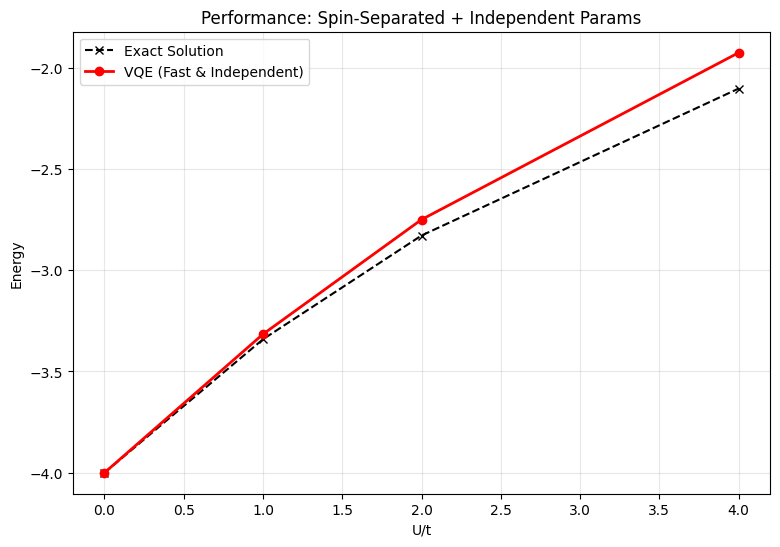


--- Cấu trúc mạch (Vẽ 1 Layer để kiểm tra) ---
Số lượng tham số (1 rep): 12 (Kỳ vọng: 12)


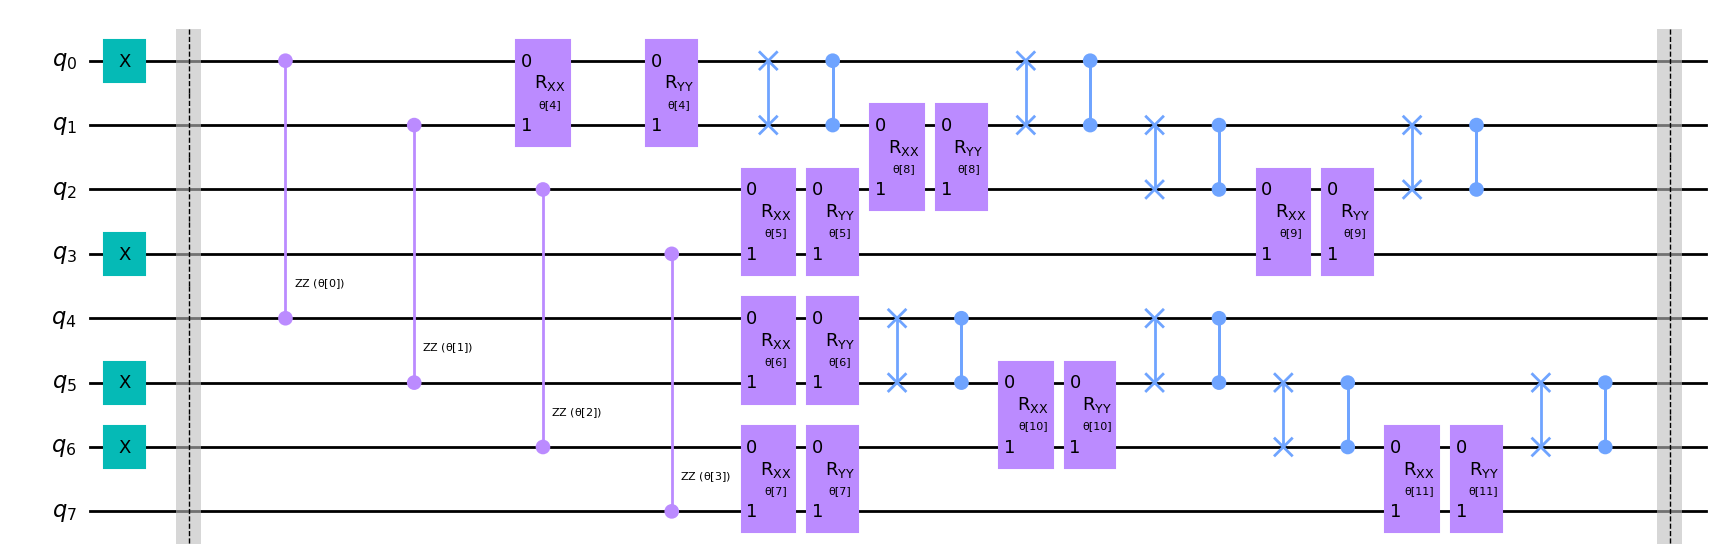

In [5]:
# --- 5. MAIN ---
def main():
    t = 1.0
    U_values = [0.0, 1.0, 2.0, 4.0]
    reps = 4

    print(f"--- 2x2 FERMI-HUBBARD (FAST & ACCURATE) ---")
    print("-" * 80)
    print(f"{'U/t':<10} | {'VQE Energy':<15} | {'Exact Energy':<15} | {'Error':<10}")
    print("-" * 80)

    mapper = JordanWignerMapper()
    prev_params = None
    vqe_Es, exact_Es = [], []

    for U in U_values:
        # Hamiltonian
        ferm_op = build_fermi_hubbard_2x2_op(t, U)
        qubit_op = mapper.map(ferm_op)

        # Exact Benchmark
        num_op = mapper.map(FermionicOp({f"+_{i} -_{i}": 1.0 for i in range(8)}, num_spin_orbitals=8))
        filter_fn = lambda s, v, a: np.isclose(a['NumberOp'][0], 4, atol=1e-2)
        solver = NumPyMinimumEigensolver(filter_criterion=filter_fn)
        exact_res = solver.compute_minimum_eigenvalue(qubit_op, aux_operators={'NumberOp': num_op})
        exact_E = exact_res.eigenvalue.real
        exact_Es.append(exact_E)

        # Run VQE
        ansatz = create_2x2_spin_separated_independent_ansatz(reps=reps)
        vqe_E, opt_params = run_vqe(qubit_op, ansatz, initial_params=prev_params)

        vqe_Es.append(vqe_E)
        prev_params = opt_params

        print(f"{U:<10} | {vqe_E:<15.6f} | {exact_E:<15.6f} | {abs(vqe_E - exact_E):<10.6f}")

    # Plot
    plt.figure(figsize=(9, 6))
    plt.plot(U_values, exact_Es, 'k--x', label='Exact Solution')
    plt.plot(U_values, vqe_Es, 'r-o', label='VQE (Fast & Independent)', linewidth=2)
    plt.xlabel('U/t')
    plt.ylabel('Energy')
    plt.title('Performance: Spin-Separated + Independent Params')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- PHẦN VẼ MẠCH ---
    print("\n--- Cấu trúc mạch (Vẽ 1 Layer để kiểm tra) ---")
    # Tạo mạch mẫu reps=1 để vẽ cho gọn
    sample_qc = create_2x2_spin_separated_independent_ansatz(reps=1)

    print(f"Số lượng tham số (1 rep): {sample_qc.num_parameters} (Kỳ vọng: 12)")

    # Vẽ mạch bằng Matplotlib (style='clifford')
    try:
        display(sample_qc.draw(output='mpl', style='clifford', fold=-1))
    except:
        print(sample_qc.draw())

if __name__ == "__main__":
    main()